In [4]:
import numpy as np
import scipy
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
from astroML.utils import split_samples
from sklearn.naive_bayes import GaussianNB
from astroML.utils import completeness_contamination
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from astroML.classification import GMMBayes
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import itertools

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [8,5]
%config InlineBackend.figure_format='retina'

In [5]:
def read (data):
    
    u_g = np.array(data['u'] - data['g'])
    g_r = np.array(data['g'] - data['r'])
    r_i = np.array(data['r'] - data['i'])
    i_z = np.array(data['i'] - data['z'])
    label = np.array(data['class'])
    label[label == 'QSO'] = 1
    label[label == 'GALAXY'] = 0
    return np.column_stack((u_g, g_r, r_i, i_z)), label.astype(int)

In [6]:
data_ = pd.read_csv("galaxyquasar.csv", sep = ',')
X, y = read(data_)
l_colors = ['u-g','g-r','r-i', 'i-z']
Ncolors = np.arange(len(l_colors)) +1

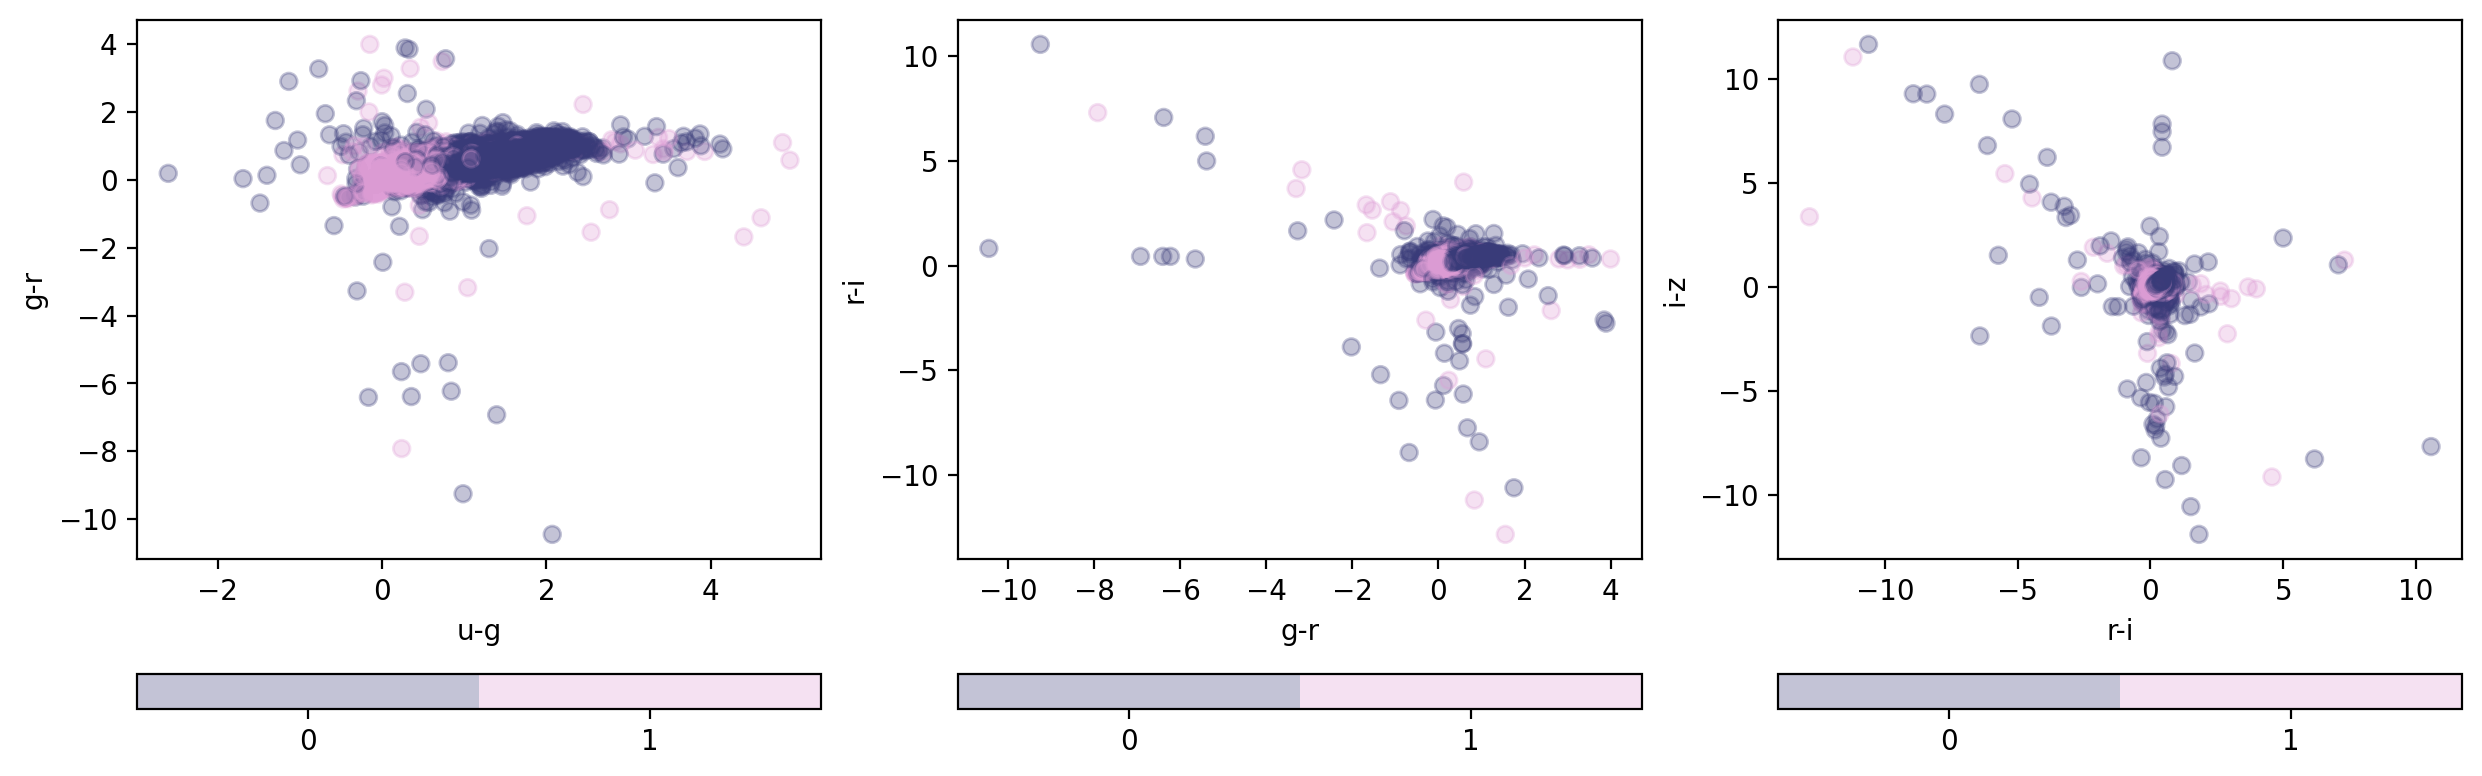

In [4]:
fig = plt.figure(figsize=(15,5))
for i in range(3):
    ax = fig.add_subplot(131+i)
    ax.set_xlabel(l_colors[i])
    ax.set_ylabel(l_colors[i+1])
    sc = ax.scatter(X[:,i],X[:,i+1], cmap=plt.cm.get_cmap('tab20b', 2), c=y, alpha=0.3, vmin=-0.5, vmax=1.5)
    fig.colorbar(sc, ticks=([0,1]), location='bottom')
plt.show()

## ROC curves for different classifiers
I divide the data set in training and test sets. I fit the classification methods (GaussianNB, LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis, KNeighborsClassifier and GMMBayes) on the training set and I use them to classify the test set and evaluate their performances using ROC curves and completeness/efficiency.
For KNeighborsClassifier and GMMBayes I choose the best number of neighbors and components using cross-validation

In [7]:
np.random.seed(0)
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25])

In [8]:
def find_best_GMMB(X_train,y_train):
    scores = []
    kcomp = np.arange(1,10)
    for k in kcomp:
        clf = GMMBayes(n_components=k, tol=1E-5, covariance_type='full')
        CVpredk = cross_val_predict(clf, X_train, y_train)
        scores.append(accuracy_score(y_train, CVpredk))
    return kcomp[np.argmax(scores)]

def find_best_KNN(X_train,y_train):
    clf = KNeighborsClassifier()
    kvals = np.arange(1,20) 
    grid = GridSearchCV(clf, param_grid={'n_neighbors': kvals}, cv=5)
    grid.fit(X_train, y_train)
    return grid.best_params_['n_neighbors']

In [9]:
best_GMMB = find_best_GMMB(X_train,y_train)
print("max score of GMMBayes is for k = ", best_GMMB)

best_KNN = find_best_KNN(X_train,y_train)
print("max score for KNeighbors is for k = ", best_KNN)

max score of GMMBayes is for k =  8
max score for KNeighbors is for k =  5


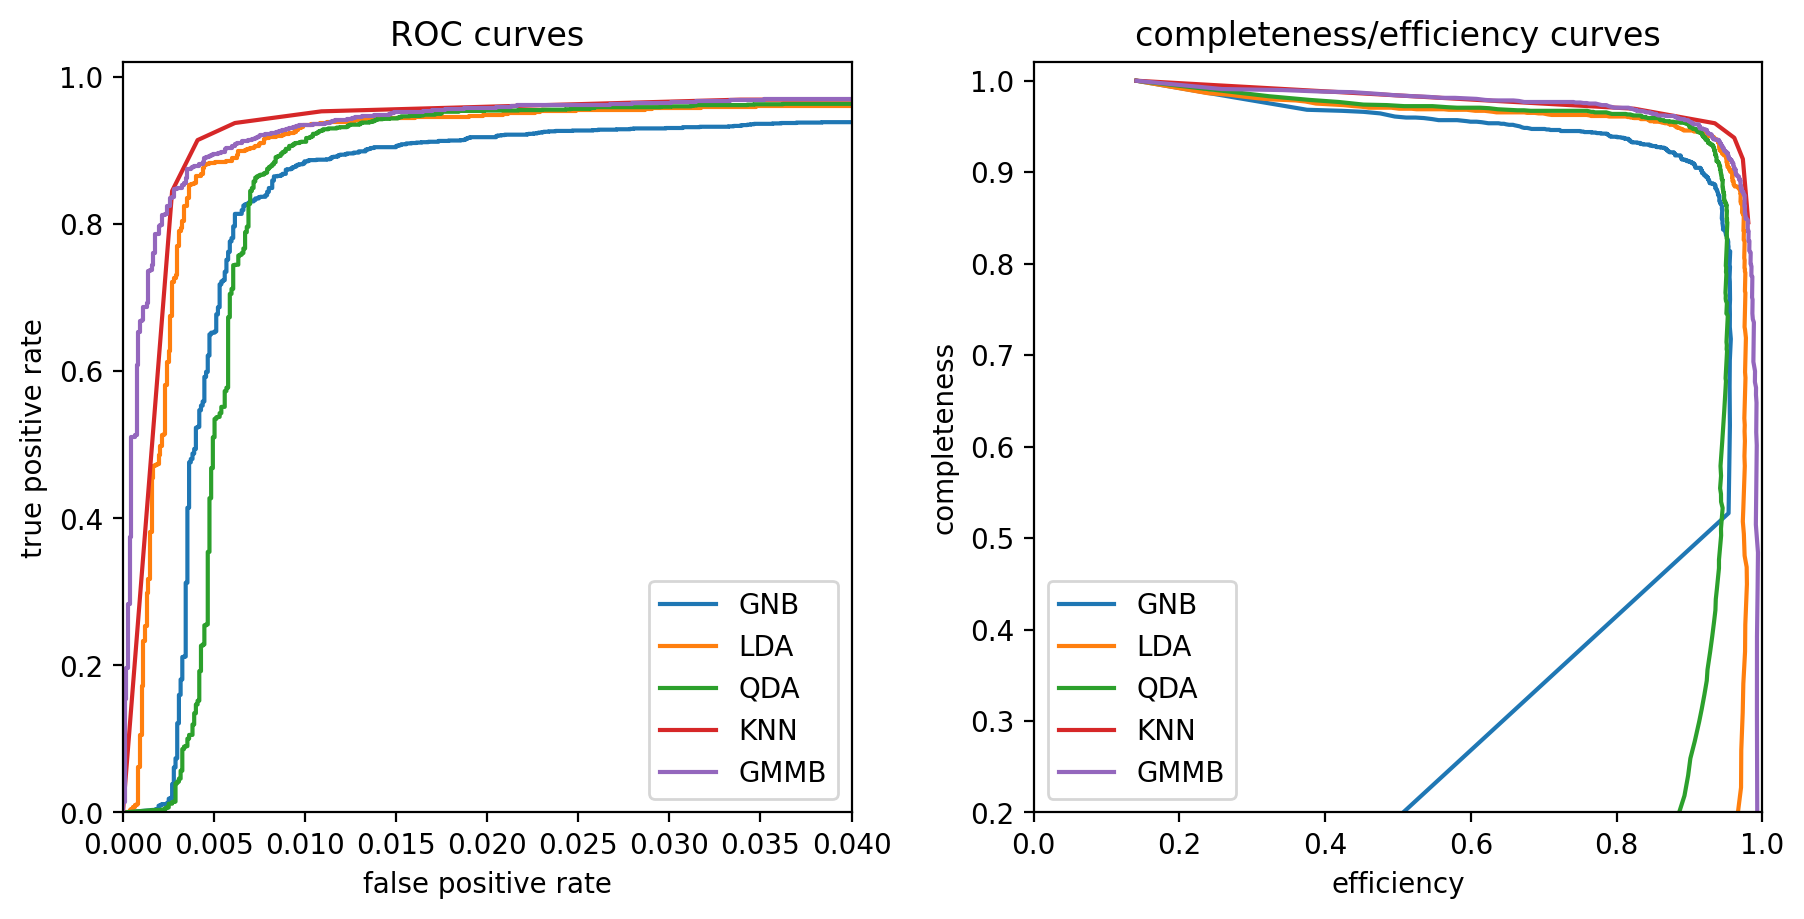

In [10]:
def compute_models(*args):
    names = []
    probs = []
    for classifier, kwargs in args:
        clf = classifier(**kwargs)
        clf.fit(X_train, y_train)
        y_probs = clf.predict_proba(X_test)[:, 1]

        names.append(classifier.__name__)
        probs.append(y_probs)

    return names, probs


names, probs = compute_models((GaussianNB, {}),
                              (LDA, {}),
                              (QDA, {}),
                              (KNeighborsClassifier,
                               dict(n_neighbors=best_KNN)),
                              (GMMBayes, dict(n_components=best_GMMB, tol=1E-5,
                                              covariance_type='full')))

#------------------------------------------------------------
# Plot ROC curves and completeness/efficiency
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

ax1 = plt.subplot(131)
ax1.set_title('ROC curves')
ax2 = plt.subplot(132)
ax2.set_title('completeness/efficiency curves')

l_class = dict(GaussianNB='GNB',
              LinearDiscriminantAnalysis='LDA',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              GMMBayes='GMMB')

thresholds = np.linspace(0, 1, 1001)
for name, y_prob in zip(names, probs):
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    precision, recall, thresh2 = precision_recall_curve(y_test, y_prob)

    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])

    ax1.plot(fpr, tpr, label=l_class[name])


    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    for i, t in enumerate(thresholds):
        y_pred = (y_prob >= t)
        comp[i], cont[i] = completeness_contamination(y_pred, y_test)
    ax2.plot(1-cont, comp, label=l_class[name])

ax1.set_xlim(0, 0.04)
ax1.set_ylim(0, 1.02)
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.legend(loc='lower right')

ax2.set_xlabel('efficiency')
ax2.set_ylabel('completeness')
ax2.set_xlim(0, 1.0)
ax2.set_ylim(0.2, 1.02)
ax2.legend(loc='lower left')
plt.show()

KNeighborsClassifier and GMMBayes performance slightly better since they reach a high TP rate with a very low FP rate, especially in respect to GNB and QDA. 

### One color
I try to classify the data with only one color and I find the one that maximizes the efficiency with GMBayes (since there are lots of galaxies I prefer to focus on low contamination)

color 0 : u-g \
color 1 : g-r \
color 2 : r-i \
color 3 : i-z 

100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.36s/it]


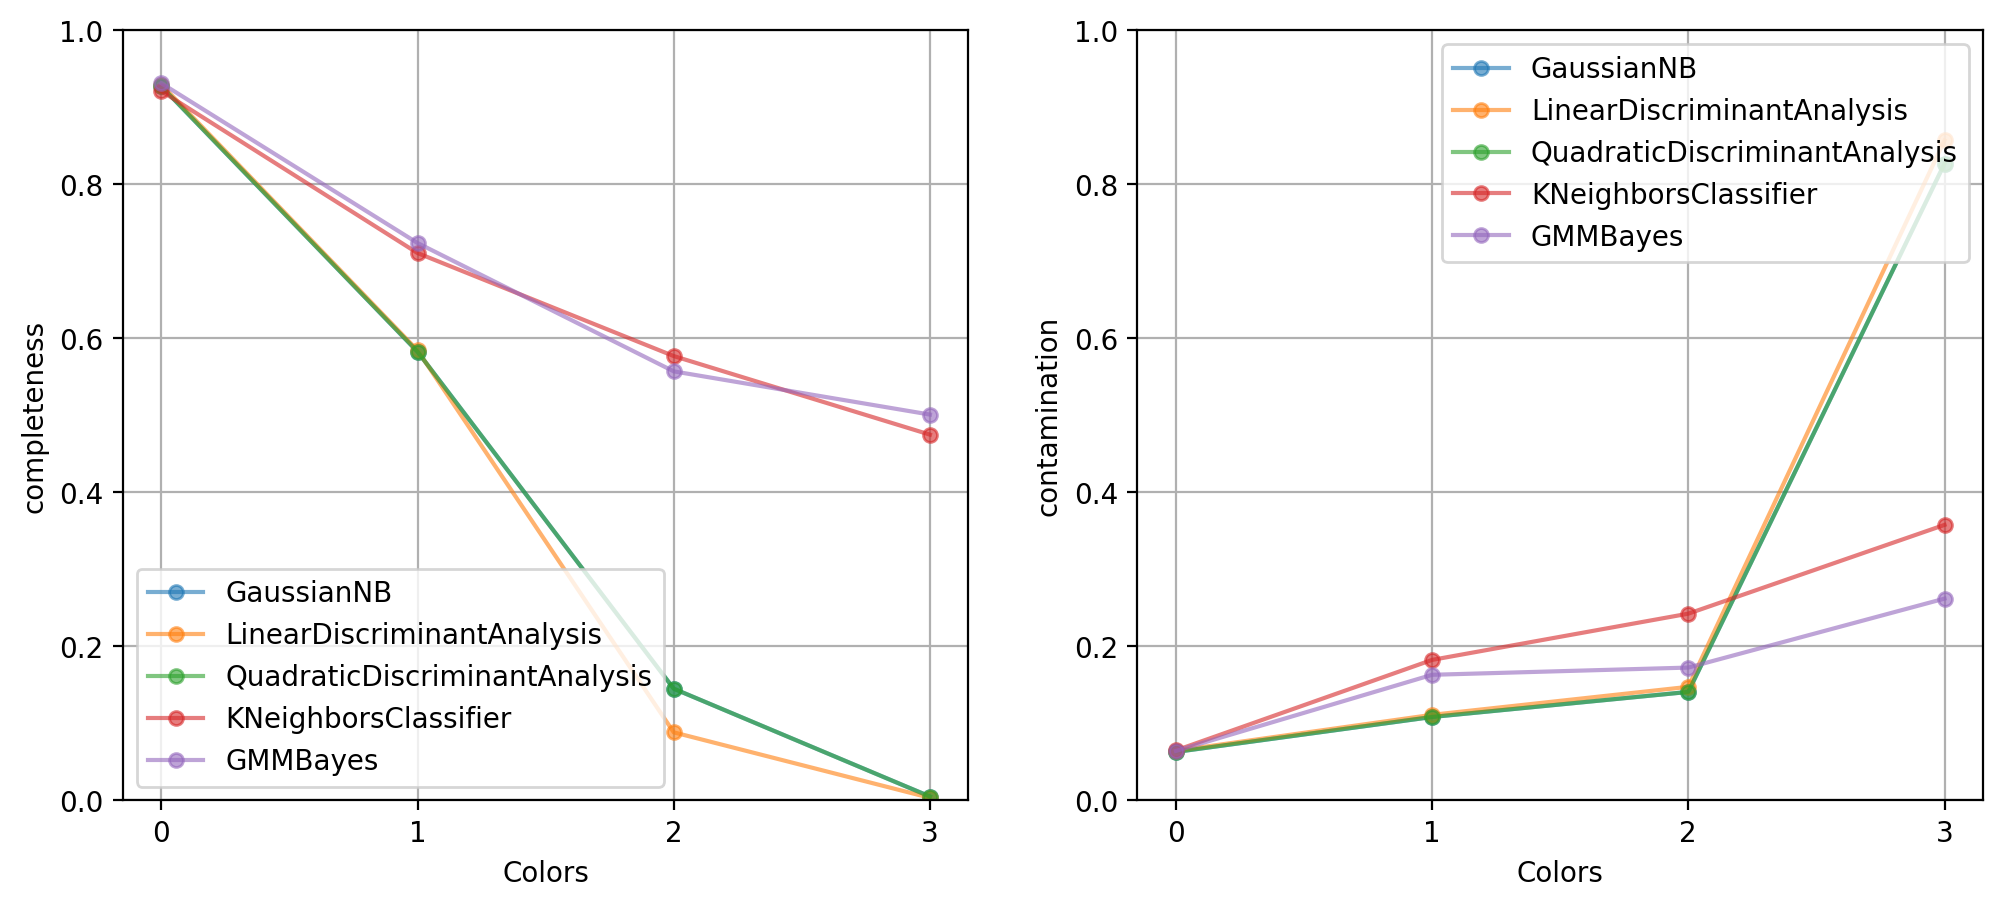

Color with higher efficiency with GMMBayes:  0


In [11]:
colors = np.arange(len(Ncolors))

def compute_models_1c(colors,*args):
    classifiers = []
    predictions = []
    for classifier, kwargs in tqdm(args):
        classifiers.append([])
        predictions.append([])
        for col in colors:
            
            clf = classifier(**kwargs)
            clf.fit(X_train[:,col][:,np.newaxis], y_train)
            y_pred = clf.predict(X_test[:,col][:,np.newaxis])
            classifiers[-1].append(clf)
            predictions[-1].append(y_pred)
    
    return classifiers, predictions
   
classifiers, predictions = compute_models_1c(colors,
                                            (GaussianNB, {}),
                                            (LDA, {}),
                                            (QDA, {}),
                                            (KNeighborsClassifier, 
                                             dict(n_neighbors=best_KNN)),
                                            (GMMBayes, dict(n_components=best_GMMB, tol=1E-5,
                                                            covariance_type='full')) )

completeness, contamination = completeness_contamination(predictions, y_test)
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
for comp,l in zip(completeness,l_class):
    ax.plot(range(len(colors)), comp, '-o',ms=5,alpha=0.6, label=l)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('Colors')
ax.set_ylabel('completeness')
ax.set_ylim(0, 1)
ax.grid(True)
ax.legend(loc = 'lower left')

ax = fig.add_subplot(122)
for cont,l in zip(contamination,l_class):
    ax.plot(range(len(colors)), cont, '-o',ms=5,alpha=0.6, label=l)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('Colors')
ax.set_ylabel('contamination')
ax.set_ylim(0, 1)
ax.grid(True)
ax.legend(loc = 'upper right')
plt.show()

best_col = colors[np.argmin(contamination[4])]
print('Color with higher efficiency with GMMBayes: ', best_col)

(GaussianNB is not visible in the plot because its curves are the same as QuadraticDiscriminantAnalysis)

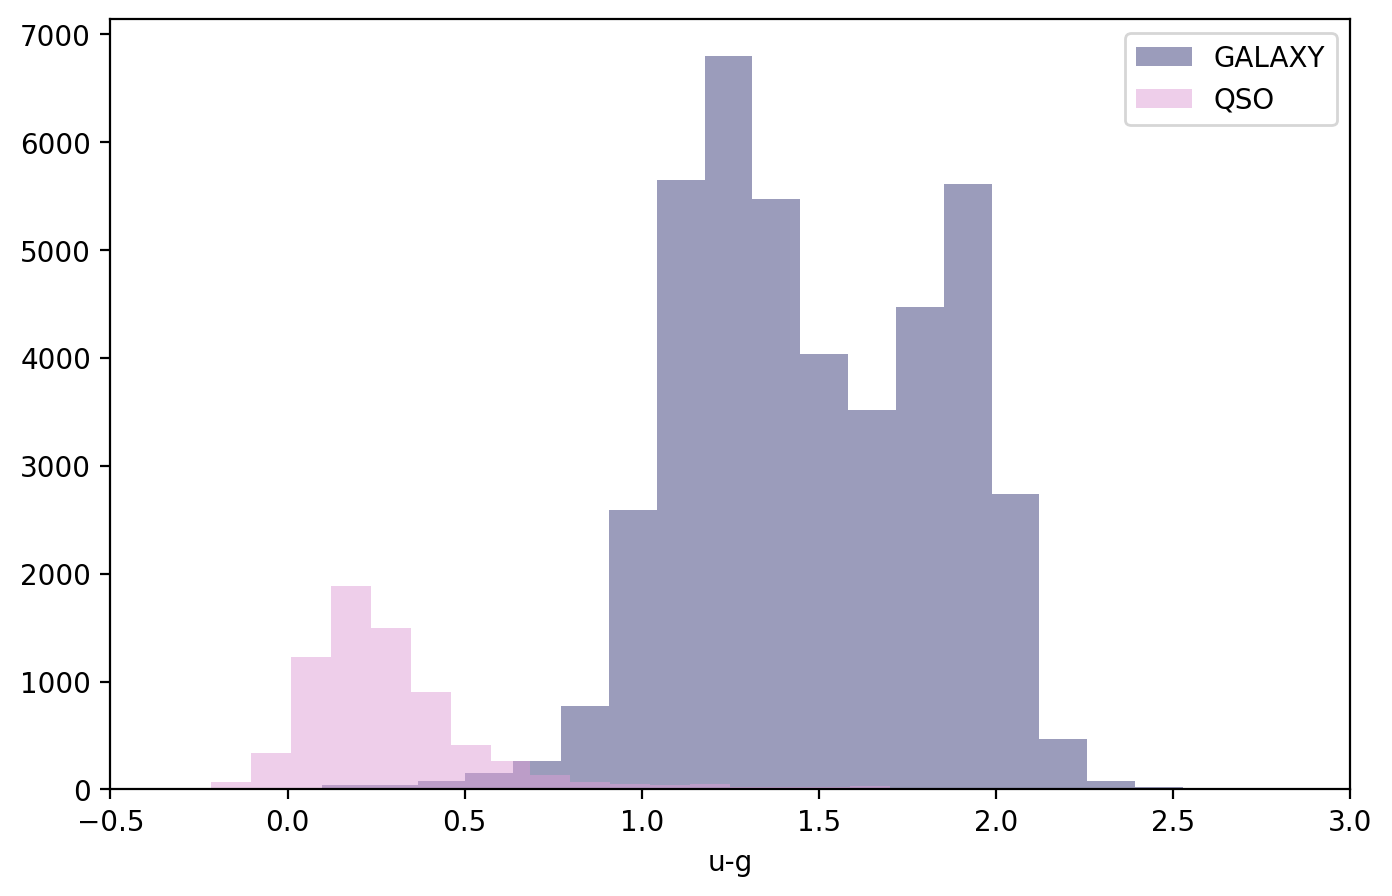

In [12]:
plt.xlabel(l_colors[best_col])
plt.hist(X[:,best_col][y==0], bins=50, color=plt.cm.get_cmap('tab20b')(0), label='GALAXY', alpha=0.5)
plt.hist(X[:,best_col][y==1], bins=50, color=plt.cm.get_cmap('tab20b')(20), label='QSO', alpha=0.5)
plt.legend()
plt.xlim(-0.5,3)
plt.show()

## Combinations of two colors
Now I search for the best combination of two colors that maximizes the efficiency with GMMBayes.\
combination 0 : (0,1) \
combination 1 : (0,2) \
combination 2 : (0,3) \
combination 3 : (1,2) \
combination 4 : (1,3) \
combination 5 : (2,3) 

100%|█████████████████████████████████████████████| 5/5 [00:18<00:00,  3.79s/it]


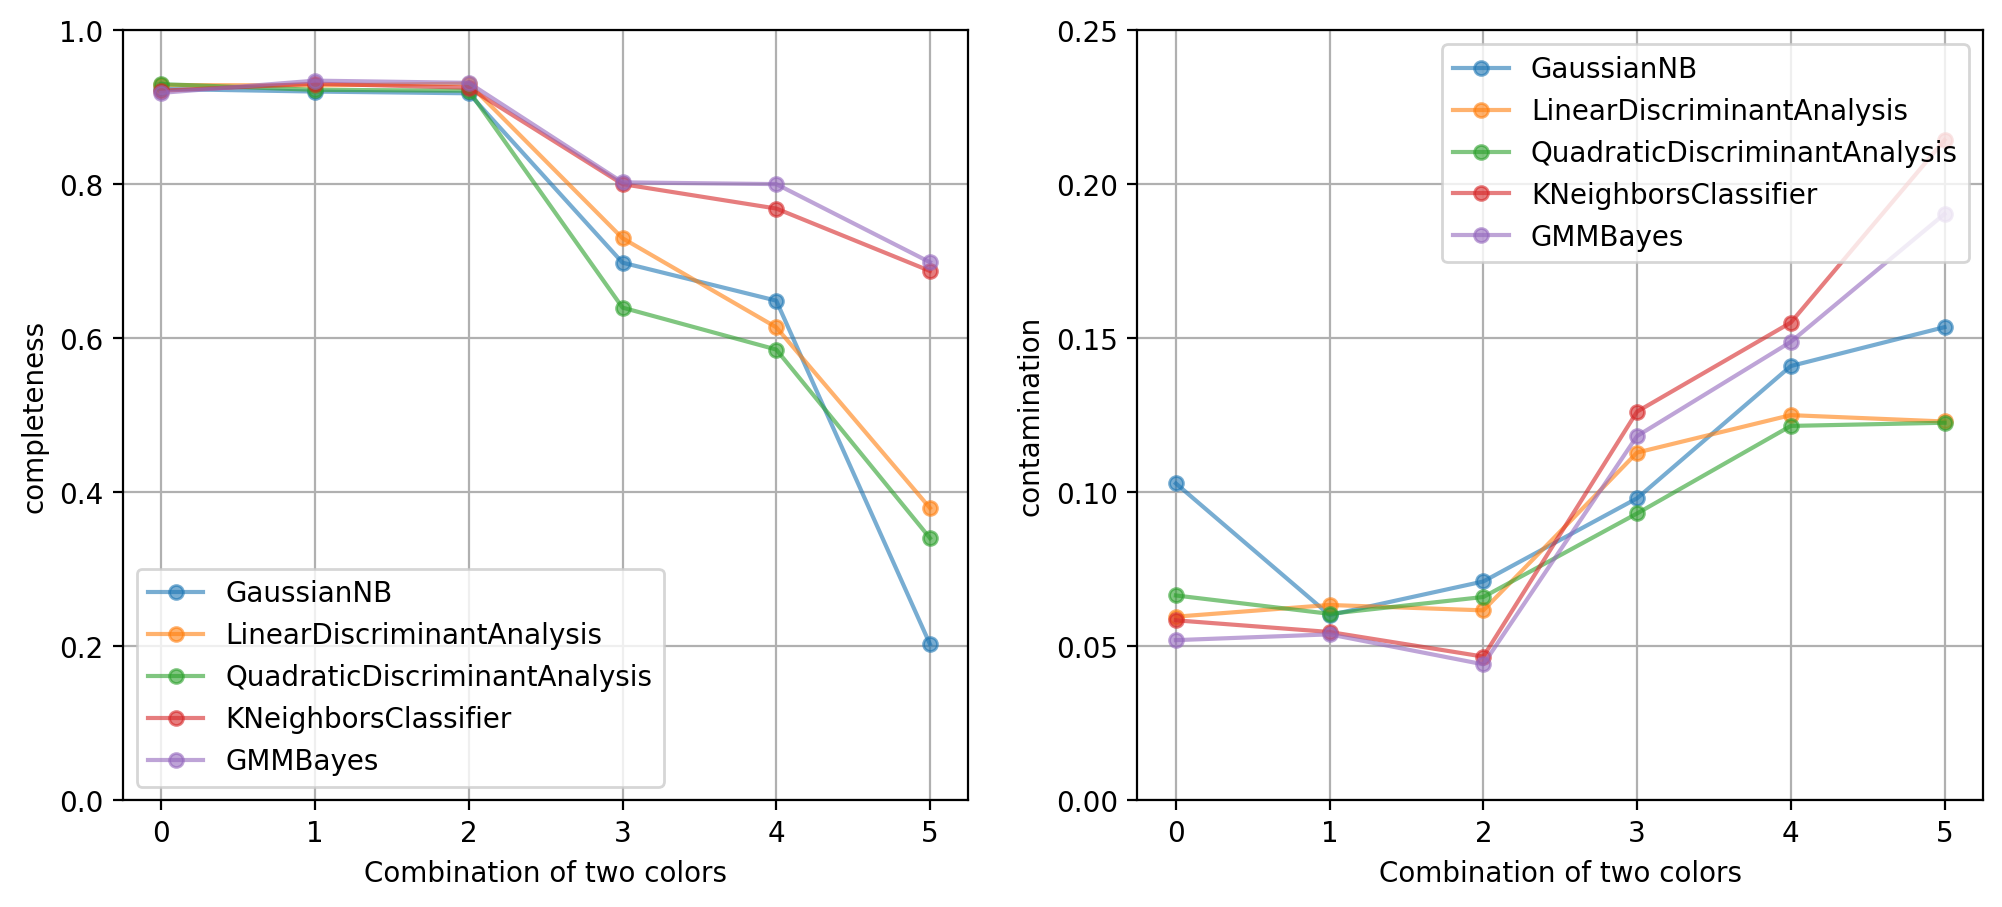

Combination of two colors with higher efficiency with GMMBayes:  (0, 3)


In [13]:
import itertools
Ncolors = np.arange(1, 5)
comb = list(itertools.combinations(Ncolors-1, 2))
N_comb = len(comb)

def compute_models_comb(combinations,*args):
    classifiers = []
    predictions = []
    for classifier, kwargs in tqdm(args):
        classifiers.append([])
        predictions.append([])
        for comb in combinations:
            clf = classifier(**kwargs)
            clf.fit(X_train[:,comb], y_train)
            y_pred = clf.predict(X_test[:,comb])
            classifiers[-1].append(clf)
            predictions[-1].append(y_pred)
    
    return classifiers, predictions
   

classifiers, predictions = compute_models_comb(comb,
                                           (GaussianNB, {}),
                                            (LDA, {}),
                                            (QDA, {}),
                                            (KNeighborsClassifier, 
                                             dict(n_neighbors=best_KNN)),
                                            (GMMBayes, dict(n_components=best_GMMB, tol=1E-5,
                                                            covariance_type='full')) )

completeness, contamination = completeness_contamination(predictions, y_test)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
for c,l in zip(completeness,l_class):
    ax.plot(range(N_comb), c, '-o',ms=5,alpha=0.6, label=l)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('Combination of two colors')
ax.set_ylabel('completeness')
ax.set_ylim(0, 1)
ax.grid(True)
ax.legend(loc = 'lower left')

ax = fig.add_subplot(122)
for c,l in zip(contamination,l_class):
    ax.plot(range(N_comb), c, '-o',ms=5,alpha=0.6, label=l)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('Combination of two colors')
ax.set_ylabel('contamination')
ax.set_ylim(0, 0.25)
ax.grid(True)
ax.legend(loc = 'upper right')
plt.show()

best_comb2 = comb[np.argmin(contamination[4])]
print('Combination of two colors with higher efficiency with GMMBayes: ', best_comb2)

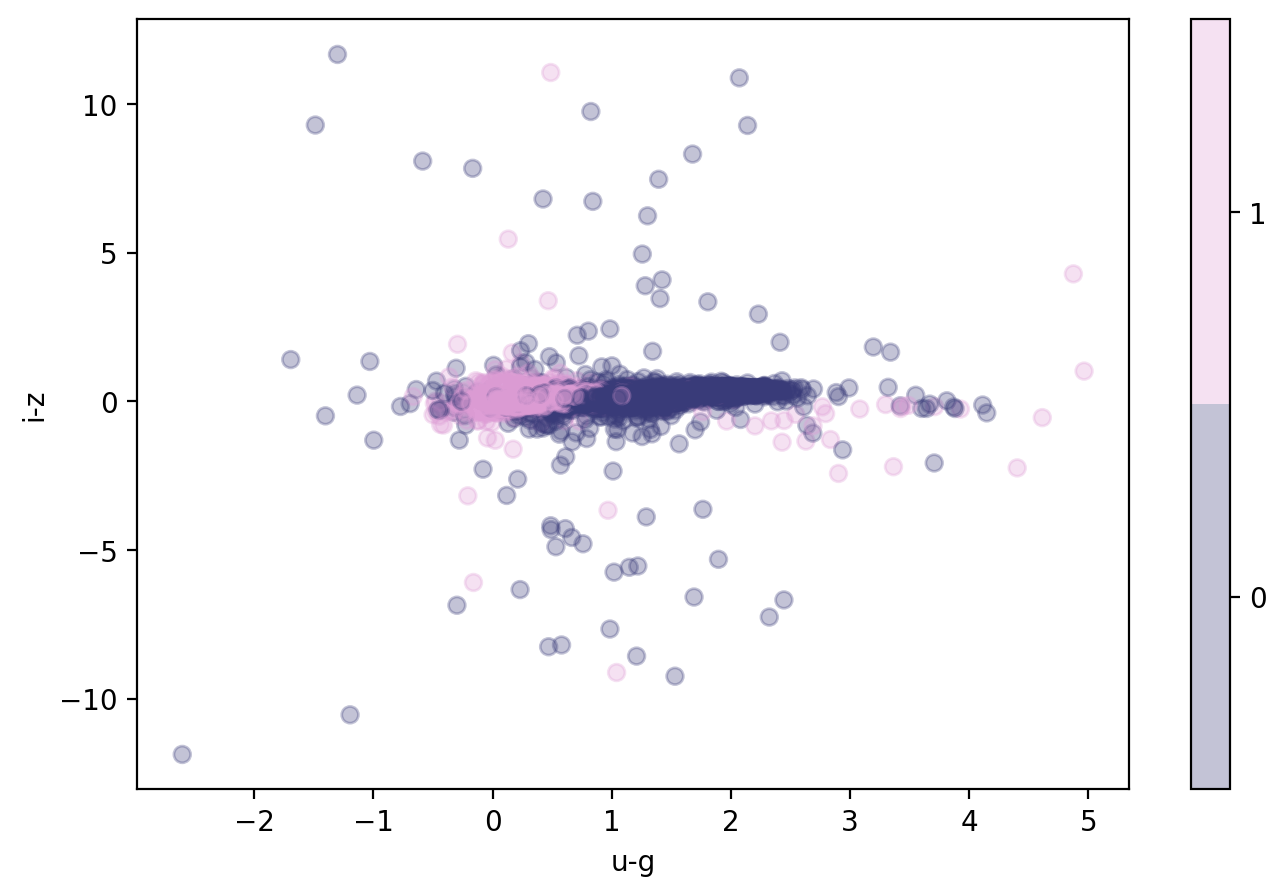

In [14]:
plt.xlabel(l_colors[best_comb2[0]])
plt.ylabel(l_colors[best_comb2[1]])
plt.scatter(X[:,best_comb2[0]], X[:,best_comb2[1]], cmap=plt.cm.get_cmap('tab20b', 2), c=y, alpha=0.3, vmin=-0.5, vmax=1.5)
plt.colorbar(ticks=([0,1]))
plt.show()

## Combinations of three colors
Now I search for the best combination of three colors that maximizes the efficiency with GMMBayes.\
combination 0 : (0,1,2) \
combination 1 : (0,1,3) \
combination 2 : (0,2,3) \
combination 3 : (1,2,3) 

100%|█████████████████████████████████████████████| 5/5 [00:12<00:00,  2.47s/it]


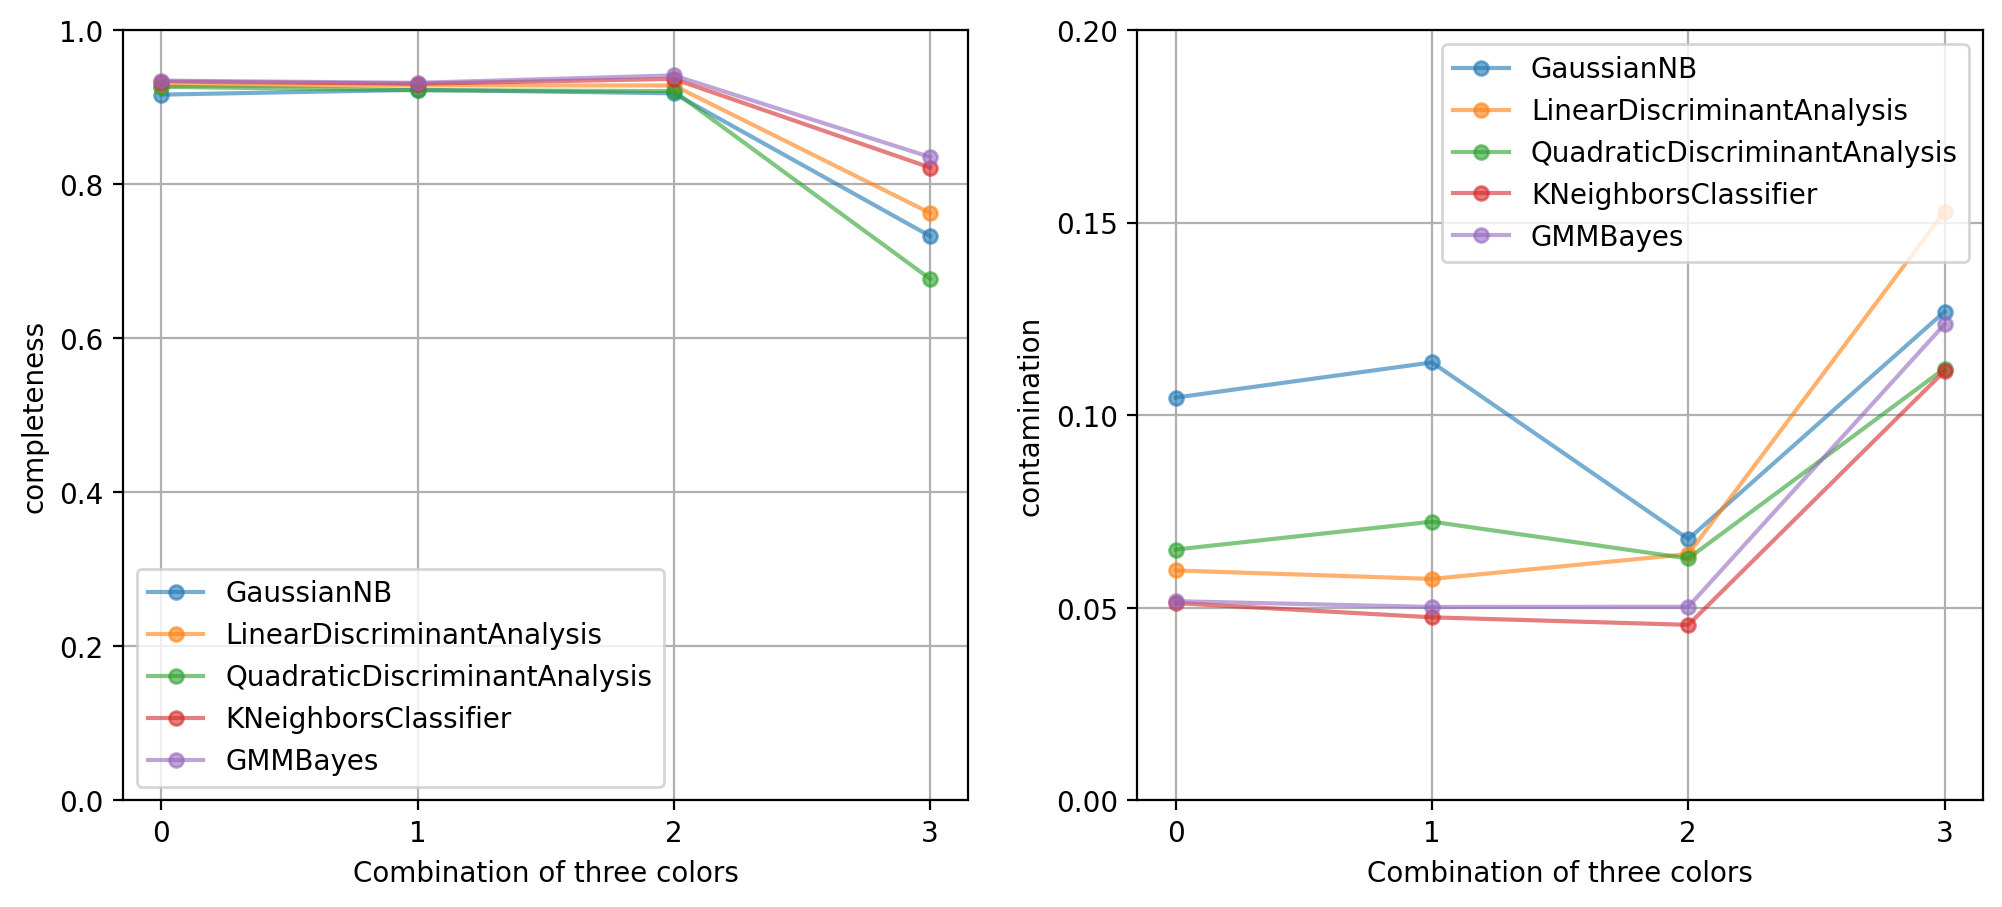

Combination of three colors with higher efficiency with GMMBayes:  (0, 1, 3)


In [15]:
Ncolors = np.arange(1, 5)
comb = list(itertools.combinations(Ncolors-1, 3))
N_comb = len(comb)  

classifiers, predictions = compute_models_comb(comb,
                                           (GaussianNB, {}),
                                            (LDA, {}),
                                            (QDA, {}),
                                            (KNeighborsClassifier, 
                                             dict(n_neighbors=best_KNN)),
                                            (GMMBayes, dict(n_components=best_GMMB, tol=1E-5,
                                                            covariance_type='full')) )

completeness, contamination = completeness_contamination(predictions, y_test)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
for c,l in zip(completeness,l_class):
    ax.plot(range(N_comb), c, '-o',ms=5,alpha=0.6, label=l)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('Combination of three colors')
ax.set_ylabel('completeness')
ax.set_ylim(0, 1)
ax.grid(True)
ax.legend(loc = 'lower left')

ax = fig.add_subplot(122)
for c,l in zip(contamination,l_class):
    ax.plot(range(N_comb), c, '-o',ms=5,alpha=0.6, label=l)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('Combination of three colors')
ax.set_ylabel('contamination')
ax.set_ylim(0, 0.2)
ax.grid(True)
ax.legend(loc = 'upper right')
plt.show()

best_comb3 = comb[np.argmin(contamination[4])]
print('Combination of three colors with higher efficiency with GMMBayes: ', best_comb3)

From all these tests it's clear that color 0 (u-g) is the one that divides better quasars and galaxies. Indeed its distribution of data has two modes that corresponds to the two labels. The other colors don't contribute much to the performance of the classification. It's interesting that color 3 alone results in the classification with lower completeness and highest contamination, but the combination of colors 0 and 3 is the best between the combinations of two colors.

### Number of colors
Now I want to know if adding more colors actually increases the performance. I evaluate the completeness and contamination as a function of the number of colors, considering the best combinations founded before using GMMBayes

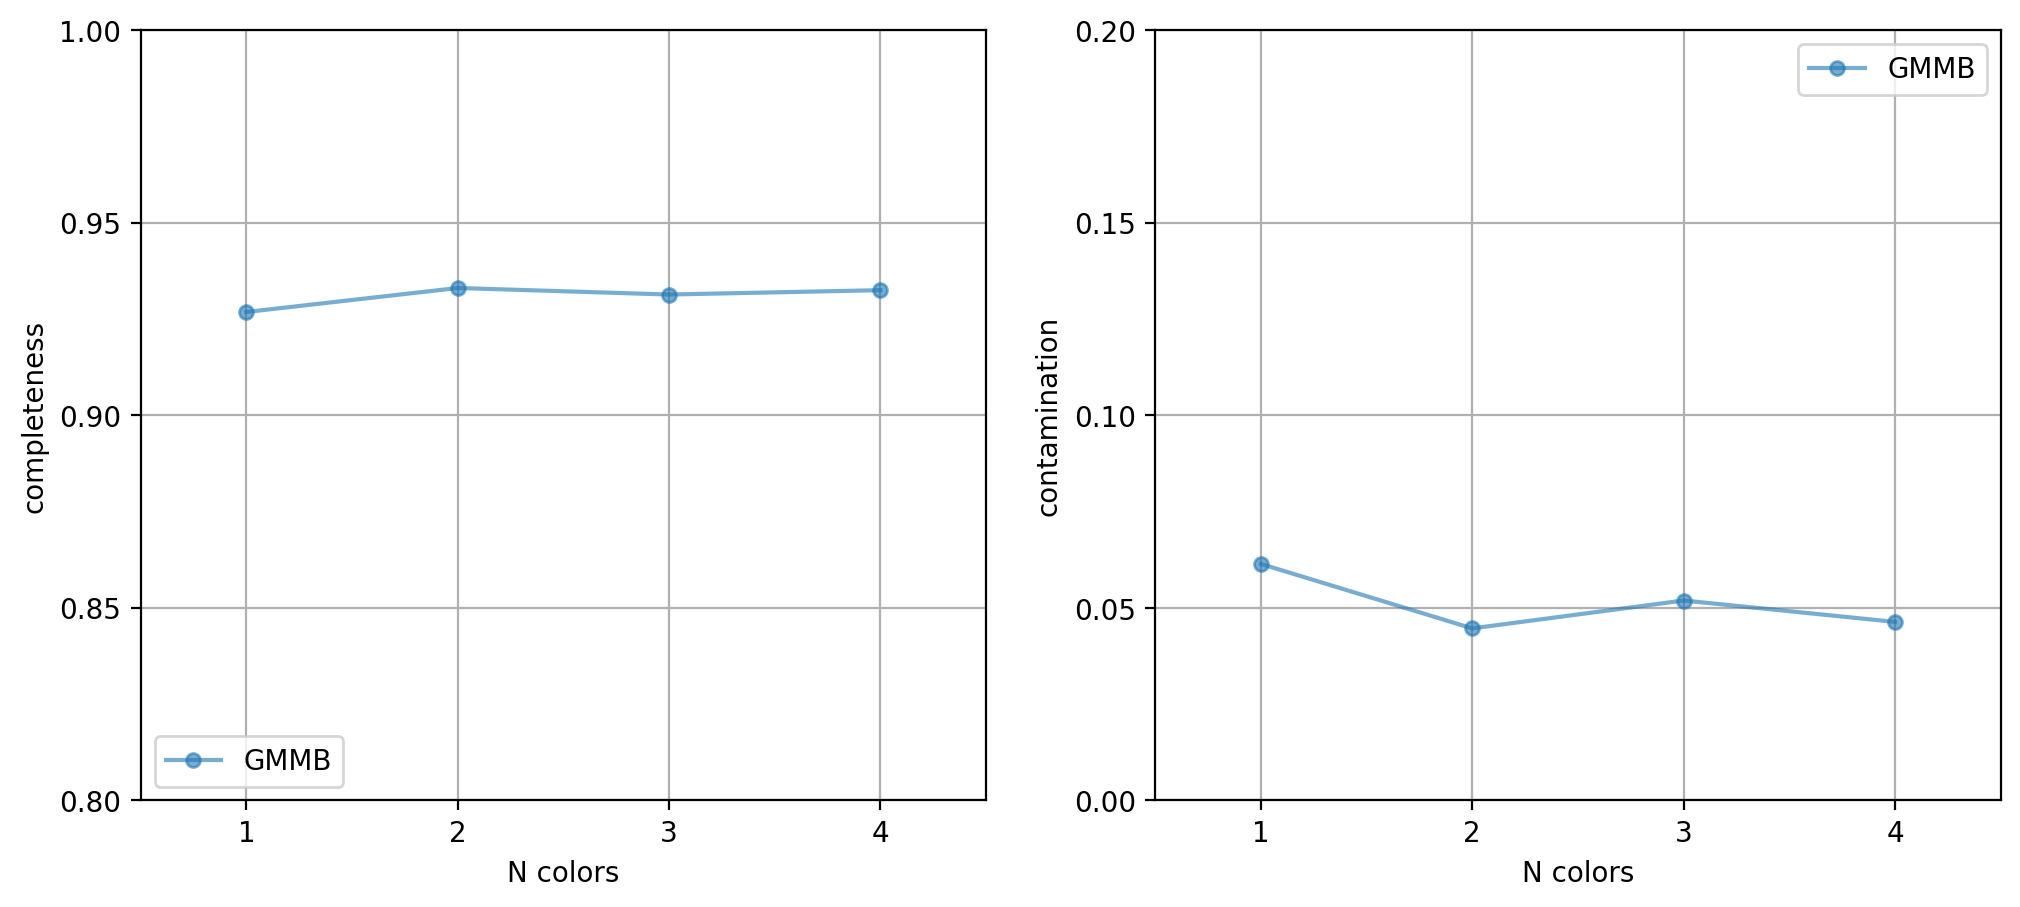

Combination of colors with higher efficiency with GMMBayes:  (0, 3)


In [16]:
comb = list([[best_col], best_comb2, best_comb3, Ncolors-1])

def compute_models_Ncol(combinations,*args):
    classifiers = []
    predictions = []
    for classifier, kwargs in args:
        classifiers.append([])
        predictions.append([])
        for comb in combinations:
            if (len(combinations)==1):
                clf = classifier(**kwargs)
                clf.fit(X_train[:,comb][:,np.newaxis], y_train)
                y_pred = clf.predict(X_test[:, comb][:,np.newaxis])
                classifiers[-1].append(clf)
                predictions[-1].append(y_pred)
            else:
               
                clf = classifier(**kwargs)
                clf.fit(X_train[:,comb], y_train)
                y_pred = clf.predict(X_test[:, comb])
                classifiers[-1].append(clf)
                predictions[-1].append(y_pred)
    
    return classifiers, predictions
   
classifiers, predictions = compute_models_Ncol(comb,
                                              (GMMBayes, dict(n_components=best_GMMB, tol=1E-5,
                                                            covariance_type='full')) )

completeness, contamination = completeness_contamination(predictions, y_test)

fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(121)
ax.plot(Ncolors, completeness.flatten(),'-o',ms=5,alpha=0.6, label='GMMB')

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('N colors')
ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(0.8, 1)
ax.grid(True)
ax.legend(loc = 'lower left')

ax = fig.add_subplot(122)
ax.plot(Ncolors, contamination.flatten(), '-o',ms=5,alpha=0.6, label='GMMB')

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(0, 0.2)
ax.grid(True)
ax.legend(loc = 'upper right')
plt.show()

best_comb = comb[np.argmin(contamination)]
print('Combination of colors with higher efficiency with GMMBayes: ', best_comb)

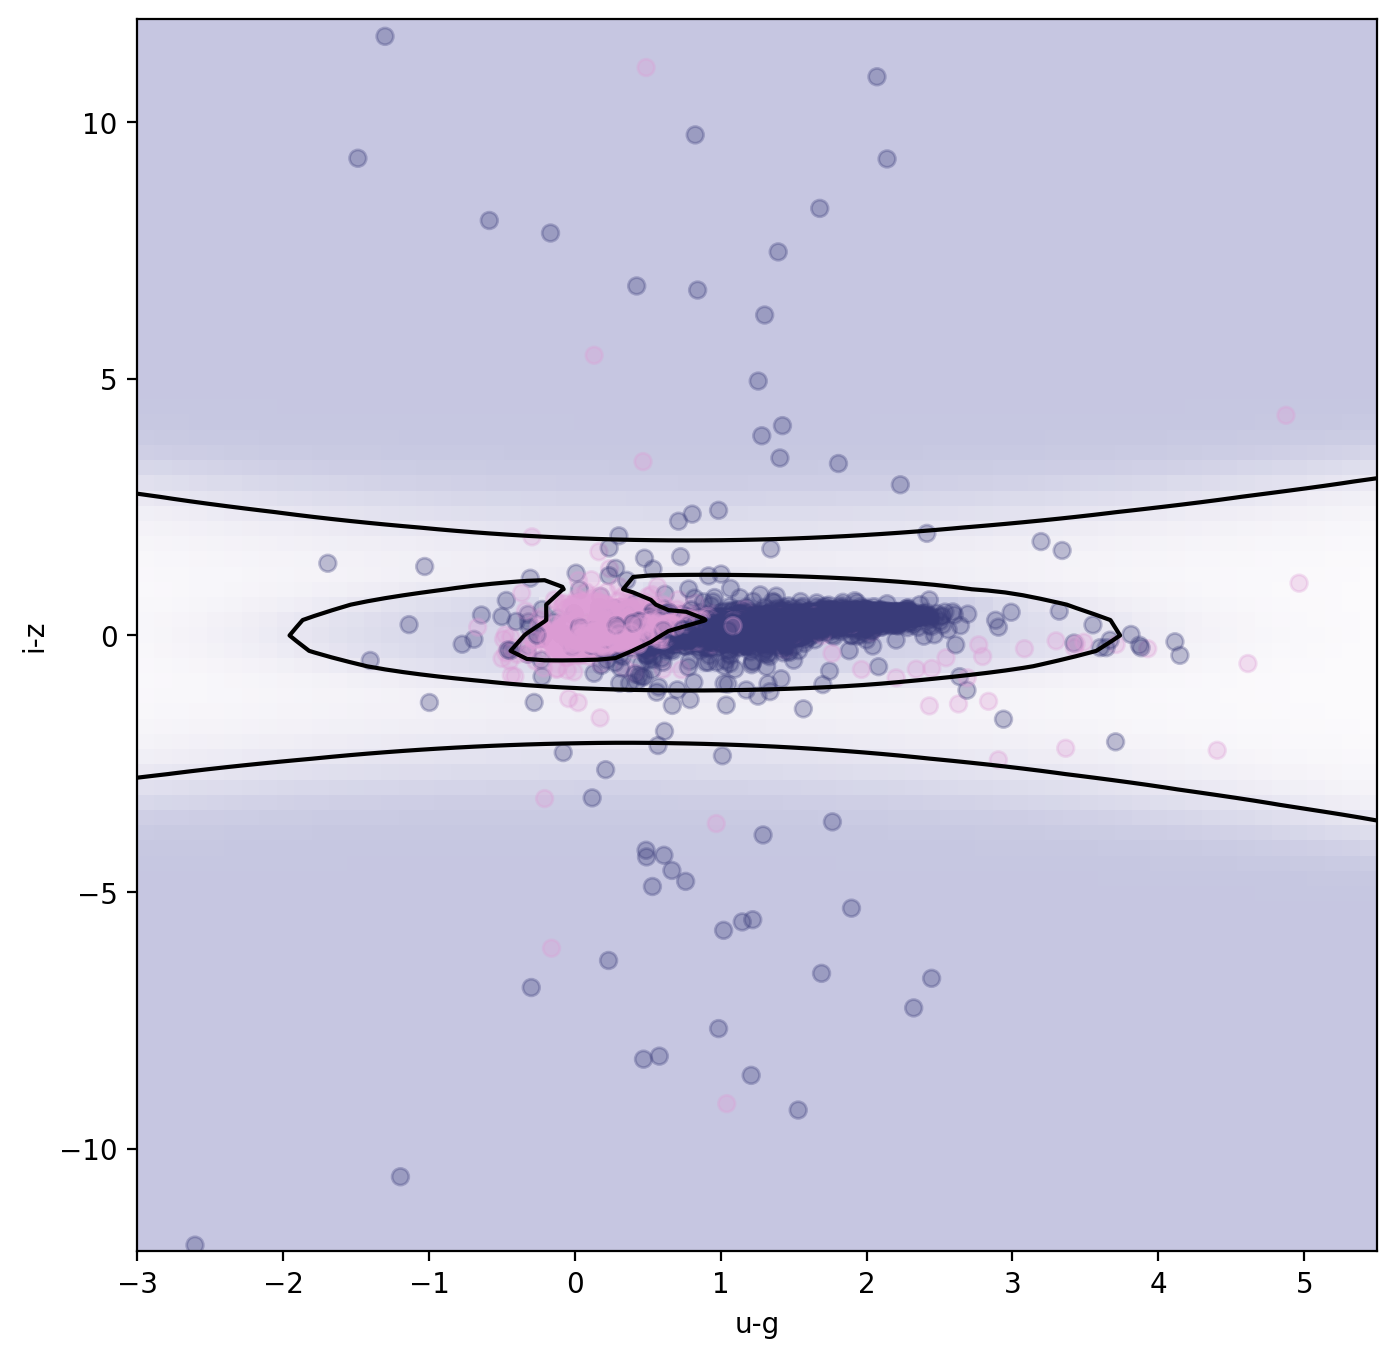

In [17]:
best_GMMB = find_best_GMMB(X_train[:,best_comb],y_train)
clf = GMMBayes(n_components=best_GMMB, tol=1E-5,covariance_type='full')
clf.fit(X_train[:,best_comb], y_train)

xlim = (-3, 5.5)
ylim = (-12, 12)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 0].reshape(xx.shape)

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot()
im = ax.imshow(Z, origin='lower', aspect='auto', cmap=plt.cm.Purples, extent=xlim + ylim)
im.set_clim(0, 3)
im = ax.scatter(X[:,best_comb[0]], X[:,best_comb[1]], cmap=plt.cm.get_cmap('tab20b', 2), c=y, alpha=0.3, vmin=-0.5, vmax=1.5)

ax.contour(xx, yy, Z, [0.5],colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(l_colors[best_comb[0]])
ax.set_ylabel(l_colors[best_comb[1]])
plt.show()